# Tumor_Detection

A machine learning model classify brain tumor images from a provided MRI dataset into distinct categories. The dataset consists of multiple MRI scans of brain tumors, and the goal is to develop a model that accurately classifies the tumor type or predicts the presence of a tumor based on MRI images.


**Section 0: Import Libraries**

We start by importing the necessary libraries and checking for GPU availability to speed up computation, which is especially useful for image classification tasks.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [21]:
 #!pwd
 #!cd /kaggle/input/tumor-x
 #!unzip Yes_No_Tumor.zip
 #!pwd
 #!rm -rf /kaggle/input/tumor-x/no

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teamnepal/week-7-brain-tumor-classification-dataset")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/week-7-brain-tumor-classification-dataset...
Path to dataset files: /kaggle/input/week-7-brain-tumor-classification-dataset


Class names in order: ['Brain_Tumor']
Class distribution: Counter({0: 7023})
Original sizes of the first 5 images:
Image 0: (512, 512) (Class: Brain_Tumor)
Image 1: (512, 512) (Class: Brain_Tumor)
Image 2: (512, 512) (Class: Brain_Tumor)
Image 3: (512, 512) (Class: Brain_Tumor)
Image 4: (512, 512) (Class: Brain_Tumor)


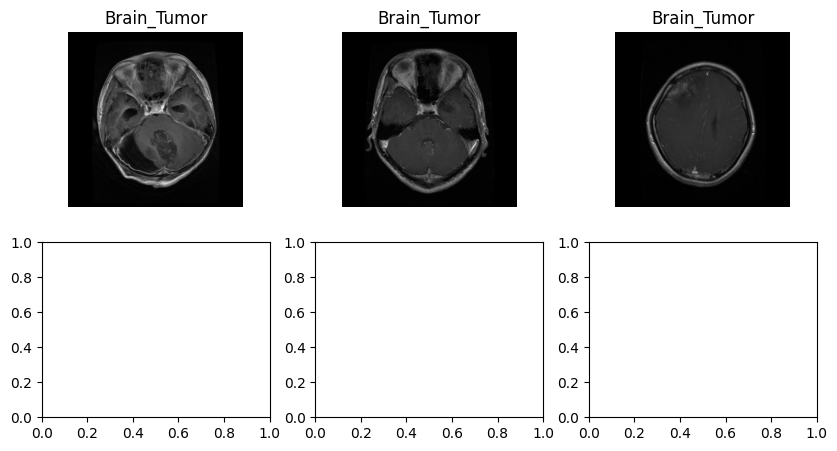

In [20]:
# Define the dataset path
data_dir = '/kaggle/input/week-7-brain-tumor-classification-dataset'
# Load the dataset without transformations
dataset = datasets.ImageFolder(root=data_dir)

print("Class names in order:", dataset.classes)

# Count images per class
class_counts = Counter([label for _, label in dataset.samples])
print(f'Class distribution: {class_counts}')

# Print sizes of the first 5 images
print("Original sizes of the first 5 images:")
for i in range(5):
    img_path, label = dataset.samples[i]
    with Image.open(img_path) as img:
        print(f'Image {i}: {img.size} (Class: {dataset.classes[label]})')


# Function to plot samples
def plot_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(10, 5))
    for i, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label == i]
        for j in range(num_samples):
            img_path, _ = dataset.samples[class_indices[j]]
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    plt.show()

# Display samples
plot_samples(dataset)

**Section 1: Load Data**

Next, we load the MRI dataset from Kaggle and explore its structure. The dataset contains images in two folders: "yes" (tumor) and "no" (no tumor).

Total images: 7023
Training images: 5618
Testing images: 1405
Classes: ['Brain_Tumor']


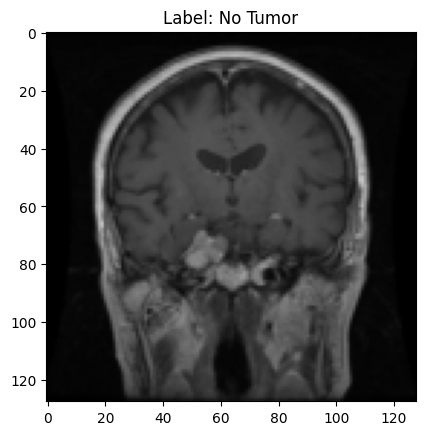

In [23]:
# Define the path to the dataset (specific to Kaggle environment)
data_dir = '/kaggle/input/week-7-brain-tumor-classification-dataset'
# Set path to the dataset directory

# Define basic transformations for loading the images
transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to 128x128 pixels
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)  # Load dataset from data_dir with the specified transform

# Split into training and testing sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, lengths=[train_size, test_size])  # Randomly split dataset into train and test sets

# Explore the dataset
print(f'Total images: {len(dataset)}')
print(f'Training images: {len(train_dataset)}')
print(f'Testing images: {len(test_dataset)}')
print(f'Classes: {dataset.classes}')

# Visualize a sample image
sample_img, sample_label = train_dataset[5]
plt.imshow(sample_img.permute(1, 2, 0))  # Display the image (make sure to permute for correct format)
plt.title(f'Label: {"Tumor" if sample_label == 1 else "No Tumor"}')
plt.show()

**Section 2: Preprocessing**

Preprocessing prepares the data for training by applying transformations like normalization and data augmentation to improve model performance.

In [24]:
# Define transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to a consistent size (e.g., 128x128)
    transforms.RandomHorizontalFlip(), # Apply random horizontal flips
    transforms.RandomRotation(10),  # Apply random rotations
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize images with pre-defined mean and std values
])

# Define transformations for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize images
])

# Apply transformations to the datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)  # DataLoader for training set with batch_size and shuffle=True
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)   # DataLoader for test set with batch_size and shuffle=False

**Section 3: Define Hyperparameters**

Hyperparameters control the training process and need to be set before defining and training the model.

In [25]:
batch_size = 32
epochs = 25
learning_rate = 0.001

**Section 4: Define the Network**

We design a simple convolutional neural network (CNN) to classify the MRI images.

In [26]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=3, padding=1)  # First convolutional layer (input: 3 channels, output: 16)
        self.pool = nn.MaxPool2d(2,2)   # Max pooling layer with 2x2 kernel
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32)
        self.fc1 = nn.Linear(32*32*32, 128)    # Fully connected layer (input: flattened conv output, output: 128)
        self.fc2 = nn.Linear(128, 2)     # Final fully connected layer for 2 output classes (binary classification) nn.Flatten()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply relu + conv1 + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply relu + conv2 + pool
        x = x.view(-1, 32*32*32)  # Flatten the tensor #try nn.Flatten()
        x = torch.relu(self.fc1(x))  # Apply relu + fc1
        x = self.fc2(x)  # Output layer (fc2)
        return x

# Instantiate the model and move it to the GPU if available
model = TumorClassifier()  # Create instance of TumorClassifier and move to device
model = model.to("cuda")
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Set loss function (e.g., CrossEntropyLoss)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Set optimizer (e.g., Adam with model parameters and learning rate)


TumorClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


**Section 5: Train the Network**

We train the model by feeding the training data through the network and updating weights based on the loss.

In [27]:
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to the appropriate device (CPU/GPU)
        
        optimizer.zero_grad()  # Clear previous gradients
        
        outputs = model(images)  # Perform forward pass through the model
        
        loss = criterion(outputs,labels)  # Calculate the loss using criterion
        
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update model weights
        
        running_loss += loss.item()  # Accumulate the loss value
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/25, Loss: 0.0040
Epoch 2/25, Loss: 0.0000
Epoch 3/25, Loss: 0.0000
Epoch 4/25, Loss: 0.0000
Epoch 5/25, Loss: 0.0000
Epoch 6/25, Loss: 0.0000
Epoch 7/25, Loss: 0.0000
Epoch 8/25, Loss: 0.0000
Epoch 9/25, Loss: 0.0000
Epoch 10/25, Loss: 0.0000
Epoch 11/25, Loss: 0.0000
Epoch 12/25, Loss: 0.0000
Epoch 13/25, Loss: 0.0000
Epoch 14/25, Loss: 0.0000
Epoch 15/25, Loss: 0.0000
Epoch 16/25, Loss: 0.0000
Epoch 17/25, Loss: 0.0000
Epoch 18/25, Loss: 0.0000
Epoch 19/25, Loss: 0.0000
Epoch 20/25, Loss: 0.0000
Epoch 21/25, Loss: 0.0000
Epoch 22/25, Loss: 0.0000
Epoch 23/25, Loss: 0.0000
Epoch 24/25, Loss: 0.0000
Epoch 25/25, Loss: 0.0000


**Section 6: Perform Inference**

After training, we evaluate the model on the test set to make predictions.

In [28]:
model.eval()  # Set model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():  # Disable gradient tracking for inference
    for images, labels in test_loader:
        images = images.to('cuda')  # Move images to the appropriate device
        outputs = model(images)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get predicted class with highest score
        predictions.extend(predicted.cpu().numpy())  # Append predictions to the list
        true_labels.extend(labels.numpy())  # Append true labels to the list

**Section 7: Output**

Finally, we calculate the accuracy and visualize a sample prediction to assess the model’s performance.

Test Accuracy: 1.0000


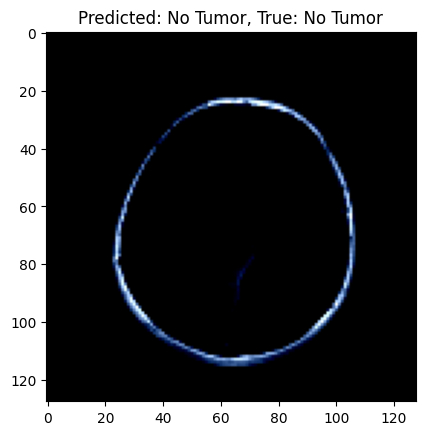

In [29]:
# Calculate accuracy
accuracy = np.mean(np.array(predictions) == np.array(true_labels))  # Compute mean of correct predictions
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize a sample prediction
index = 9  # Choose an index to visualize
sample_img, sample_label = test_dataset[index]
plt.imshow(sample_img.permute(1,2,0))  # Display the image (make sure to permute for correct format)
pred_label = predictions[index]
plt.title(f'Predicted: {"Tumor" if pred_label == 1 else "No Tumor"}, True: {"Tumor" if sample_label == 1 else "No Tumor"}')
plt.show()